## Bluebike Forecasting

Steps involved: 

1. EDA (done in separate file)
2. Outlier Removal
3. Feature Engineering 
4. Applying Models
We will use various methods to forecast the demand:
- 4.1 Linear Regression
- 4.2 XGBoost Regression

5. Comparing the results
6. Stacking the results




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

In [ ]:
# Loading the data (All trip data)
trip_data = pd.read_pickle("/content/drive/MyDrive/blue_bikes_sales_prediction/data/raw_data.pkl")

In [ ]:
trip_data.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,350,2017-01-01 00:06:58,2017-01-01 00:12:49,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,139,Dana Park,42.36178,-71.1081,644,Subscriber,NaN


In [ ]:
# importing bike station data 
bike_stations = pd.read_csv("/content/drive/MyDrive/blue_bikes_sales_prediction/data/Hubway_Stations_as_of_July_2017.csv")
bike_stations.head(3)

,Number,Name,Latitude,Longitude,District,Public,Total docks
0,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18
1,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19
2,S32023,30 Dane St,42.381001,-71.104025,Somerville,Yes,15


<Figure size 1440x432 with 0 Axes>

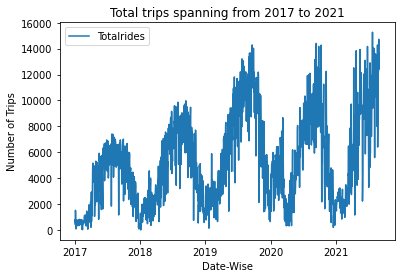

In [ ]:
plt.figure(figsize=(20,6))
df = pd.DataFrame(trip_data['starttime'].dt.date)
df = pd.DataFrame(df.groupby('starttime').size().reset_index(name='Totalrides'))
df.plot(x= 'starttime')
plt.xlabel('Date-Wise')
plt.ylabel('Number of Trips')
plt.title('Total trips spanning from 2017 to 2021')
plt.show()

### Time-step feature

In [ ]:
df['Time'] = np.arange(len(df.index))

df.head()

,starttime,Totalrides,Time
0,2017-01-01,481,0
1,2017-01-02,802,1
2,2017-01-03,651,2
3,2017-01-04,1534,3
4,2017-01-05,1330,4


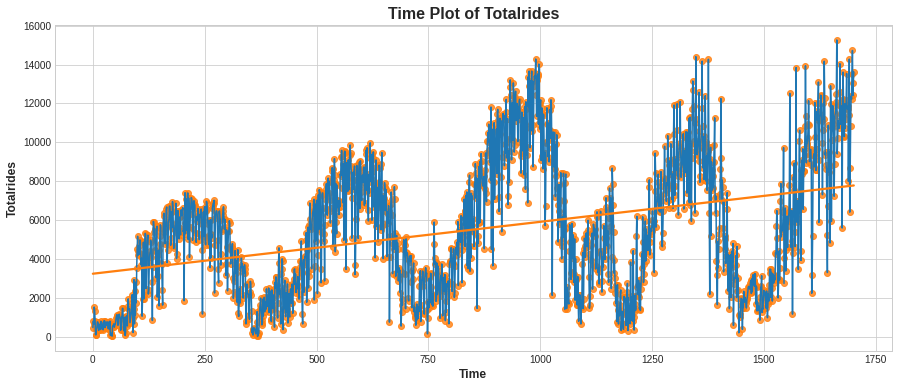

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    #autolayout=True,
    figsize=(15, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    #titlepad=10,
)
#%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Totalrides', data=df)
ax = sns.regplot(x='Time', y='Totalrides', data=df, ci=None)#, scatter_kws=dict(color='darkblue')
ax.set_title('Time Plot of Totalrides');

### Lag features
To make a lag feature we shift the observations of the target series so that they appear to have occured later in time.<br> Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [ ]:
df['Lag_1'] = df['Totalrides'].shift(1)
df = df.reindex(columns=['Totalrides', 'Lag_1'])

df.head()

,Totalrides,Lag_1
0,481,NaN
1,802,481.0
2,651,802.0
3,1534,651.0
4,1330,1534.0


In [ ]:
df.shape

(1702, 2)

 Plotting each observation in a series against the previous observation.

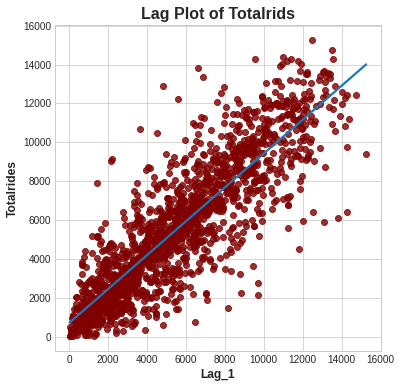

In [ ]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Totalrides', data=df, ci=None, scatter_kws=dict(color='maroon'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Totalrides');

We see high coreraltion

In [ ]:
## implementing Linear regression

In [ ]:
df = pd.DataFrame(trip_data['starttime'].dt.date)
df = pd.DataFrame(df.groupby('starttime').size().reset_index(name='Totalrides'))
df.set_index('starttime')
df['Time'] = np.arange(len(df.index))

df.head()


,starttime,Totalrides,Time
0,2017-01-01,481,0
1,2017-01-02,802,1
2,2017-01-03,651,2
3,2017-01-04,1534,3
4,2017-01-05,1330,4


In [ ]:
#splitting into test and train
train = df[df.Time < 1094]
test = df[df.Time >= 1094]
print(train.shape,test.shape)

(1094, 3) (608, 3)


(1094, 1) (1094,) (608, 1) (608,)


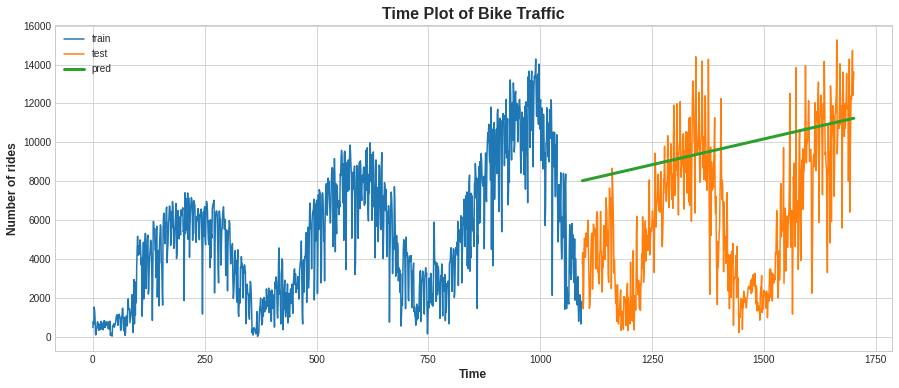

In [ ]:
from sklearn.linear_model import LinearRegression

# Training data
X = train.loc[:, ['Time']]  # features
y = train.loc[:, 'Totalrides']  # target
X_test = test.loc[:, ['Time']]  # features
y_test = test.loc[:, 'Totalrides']  # target
print(X.shape,y.shape,X_test.shape,y_test.shape)
# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X_test), index=X_test.index)

ax = y.plot(label = 'train')
ax = y_test.plot(label = 'test')
ax = y_pred.plot(ax=ax, linewidth=3,label = 'pred')
ax.set_title('Time Plot of Bike Traffic')
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides')#
plt.legend()

In [ ]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'Totalrides']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

Text(0, 0.5, 'Number of rides')

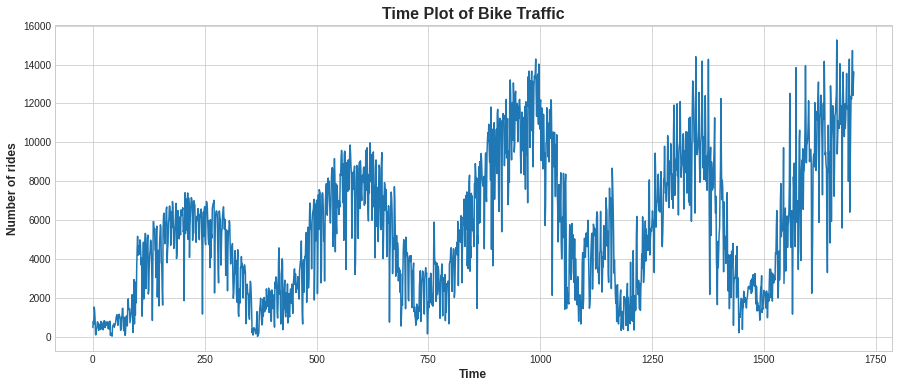

In [ ]:
ax = y.plot()
#ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Bike Traffic')
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides')#


In [ ]:
df['Lag_1'] = df['Totalrides'].shift(1)
df.head()

,starttime,Totalrides,Time,Lag_1
0,2017-01-01,481,0,NaN
1,2017-01-02,802,1,481.0
2,2017-01-03,651,2,802.0
3,2017-01-04,1534,3,651.0
4,2017-01-05,1330,4,1534.0


In [ ]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'Totalrides']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

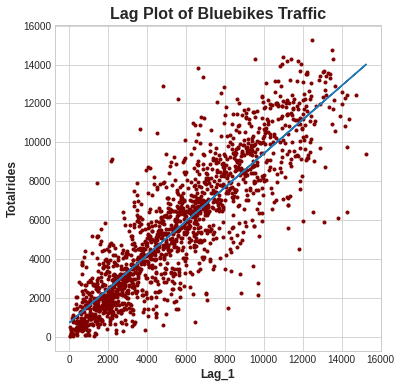

In [ ]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='maroon')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Totalrides')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Bluebikes Traffic');

Text(0, 0.5, 'Number of rides')

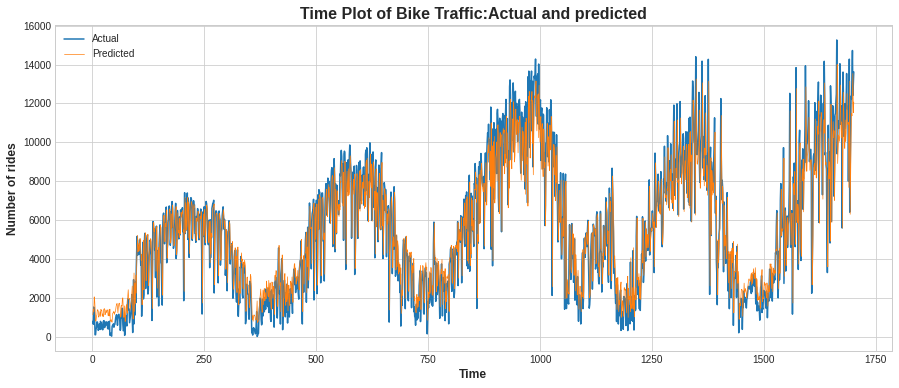

In [ ]:
ax = y.plot()
ax = y_pred.plot(ax=ax, linewidth=.7)
plt.legend(['Actual','Predicted'])
ax.set_title('Time Plot of Bike Traffic:Actual and predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides')

## XGBoost


In [ ]:
import pandas as pd
import numpy as np
raw_data = pd.read_pickle("/content/drive/MyDrive/blue_bikes_sales_prediction/data/raw_data.pkl")

In [ ]:
raw_data.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,350,2017-01-01 00:06:58,2017-01-01 00:12:49,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,139,Dana Park,42.361780,-71.108100,644,Subscriber,NaN
1,891,2017-01-01 00:13:16,2017-01-01 00:28:07,36,Boston Public Library - 700 Boylston St.,42.349673,-71.077303,10,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,230,Subscriber,NaN
2,1672,2017-01-01 00:16:17,2017-01-01 00:44:10,36,Boston Public Library - 700 Boylston St.,42.349673,-71.077303,9,Agganis Arena - 925 Comm Ave.,42.351246,-71.115639,980,Customer,NaN


##Feature Engineering


In [ ]:
#!pip install holidays
import holidays
h = holidays.US()
'01-01-2018' in h



True

In [ ]:
# grouping the data hourly 

# df = pd.DataFrame(trip_data['starttime'].dt.date)
# df = pd.DataFrame(df.groupby('starttime').size().reset_index(name='Totalrides'))

In [ ]:
# preprocessing
def preprocess(data):
  '''
  Etract day, month, hour from timestamp
  new features such as seasons and weekday and weekend
  one hot encoding
  grouping by hour

  '''
  df = data.copy()
  
  # extracting the date,hour from time stamp
  df['date'] = df.starttime.dt.date
  df['hour'] = df.starttime.dt.hour

  # getting the count by the hour
  df = df.groupby(['date','hour']).size().reset_index(name = 'Totalrides')
  df['date'] = pd.to_datetime(df['date'])
  
  # extracting the date,hour from time stamp
  df['year'] = df.date.dt.year
  df['month'] = df.date.dt.month
  df['day'] = df.date.dt.day_name()
  df['day_of_year'] = pd.to_numeric(df.date.dt.strftime('%j'))

  # new features for seasons
  df['Winter'] =df['month'].apply(lambda x: 1 if x in (12,1,2) else 0) 
  df['Spring'] =df['month'].apply(lambda x: 1 if x in (3,4,5) else 0)
  df['Summer'] =df['month'].apply(lambda x: 1 if x in (6,7,8) else 0)
  df['Fall'] =df['month'].apply(lambda x: 1 if x in (9,10,11) else 0)
  
  # new feature for weekday
  df['Weekday'] =df['day'].apply(lambda x: 1 if x not in ('Saturday','Sunday') else 0)
  df['Weekend'] =df['day'].apply(lambda x: 1 if x in ('Saturday','Sunday') else 0)
  
  # new feature for holiday
  import holidays
  holiday_list = holidays.US() 
  df['holiday'] =df['date'].apply(lambda x: 1 if x in holiday_list else 0)

  # split df into X and y
  X = df.drop(['Totalrides','date','day'],axis =1)
  y = df['Totalrides']

  # train test split
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.7,shuffle = True,random_state = 1 )

  # Scaling the data
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train),index= X_train.index,columns=X_train.columns)
  X_test = pd.DataFrame(scaler.transform(X_test),index= X_test.index,columns=X_test.columns)
  # raw_data['tripduration_mins'] = round((raw_data.tripduration)/60,0)
  # raw_data['tripduration_hours'] = round((raw_data.tripduration)/3600,0)

  return X_train,X_test,y_train,y_test

In [ ]:
X_train,X_test,y_train,y_test = preprocess(raw_data)
X_train

,hour,year,month,day_of_year,Winter,Spring,Summer,Fall,Weekday,Weekend,holiday
1994,0.787255,-1.384868,-0.677108,-0.803491,-0.567387,1.648375,-0.611405,-0.523878,0.634154,-0.634154,-0.175178
9359,0.497440,-0.644372,-1.269705,-1.327204,1.762466,-0.606658,-0.611405,-0.523878,0.634154,-0.634154,-0.175178
26237,-0.516911,0.836618,-1.566004,-1.530870,1.762466,-0.606658,-0.611405,-0.523878,-1.576903,1.576903,-0.175178
1505,-0.227097,-1.384868,-0.973407,-1.016856,-0.567387,1.648375,-0.611405,-0.523878,-1.576903,1.576903,-0.175178
23382,-0.951633,0.096123,0.804386,0.854932,-0.567387,-0.606658,-0.611405,1.908842,-1.576903,1.576903,-0.175178
...,...,...,...,...,...,...,...,...,...,...,...
7813,0.932162,-1.384868,1.693283,1.553215,1.762466,-0.606658,-0.611405,-0.523878,-1.576903,1.576903,-0.175178
32511,1.366884,0.836618,1.100685,1.010106,-0.567387,-0.606658,-0.611405,1.908842,0.634154,-0.634154,-0.175178
5192,-0.516911,-1.384868,0.508087,0.496092,-0.567387,-0.606658,1.635577,-0.523878,0.634154,-0.634154,-0.175178
12172,-0.516911,-0.644372,-0.084510,-0.163398,-0.567387,-0.606658,1.635577,-0.523878,0.634154,-0.634154,-0.175178


In [ ]:
X_test

,hour,year,month,day_of_year,Winter,Spring,Summer,Fall,Weekday,Weekend,holiday
7030,-1.386355,-1.384868,1.100685,1.242867,-0.567387,-0.606658,-0.611405,1.908842,0.634154,-0.634154,-0.175178
25391,1.656699,0.096123,1.693283,1.659897,1.762466,-0.606658,-0.611405,-0.523878,0.634154,-0.634154,-0.175178
14709,-1.241448,-0.644372,0.804386,0.864630,-0.567387,-0.606658,-0.611405,1.908842,-1.576903,1.576903,-0.175178
6611,0.207625,-1.384868,1.100685,1.068296,-0.567387,-0.606658,-0.611405,1.908842,0.634154,-0.634154,-0.175178
26828,-1.676170,0.836618,-1.269705,-1.288410,1.762466,-0.606658,-0.611405,-0.523878,0.634154,-0.634154,-0.175178
...,...,...,...,...,...,...,...,...,...,...,...
14660,-1.386355,-0.644372,0.804386,0.845233,-0.567387,-0.606658,-0.611405,1.908842,0.634154,-0.634154,-0.175178
28815,1.366884,0.836618,-0.380809,-0.483445,-0.567387,1.648375,-0.611405,-0.523878,0.634154,-0.634154,-0.175178
26907,-0.661819,0.836618,-1.269705,-1.259315,1.762466,-0.606658,-0.611405,-0.523878,-1.576903,1.576903,-0.175178
20568,1.511791,0.096123,-0.380809,-0.289477,-0.567387,1.648375,-0.611405,-0.523878,-1.576903,1.576903,-0.175178


In [ ]:
y_train

1994     404
9359      63
26237     60
1505      21
23382     18
        ... 
7813     133
32511    310
5192     822
12172    826
33003    361
Name: Totalrides, Length: 28280, dtype: int64

In [ ]:
y_test.mean()

235.71132744823035

## Training

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train,y_train)

[15:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Results

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([ 33.117912,  31.283459,  24.686907, ...,  77.594734, 201.83601 ,
        10.665126], dtype=float32)

In [ ]:
rmse = np.mean(np.sqrt((y_pred-y_test)**2))
print(round(rmse))

90


In [ ]:
y_train.describe()

count    28280.000000
mean       230.886103
std        260.134224
min          1.000000
25%         34.000000
50%        136.000000
75%        347.000000
max       1795.000000
Name: Totalrides, dtype: float64

### sum of squared errrors from the baseline model
Base line model is one which preidicts mean of the y_test for all values

In [ ]:
# baseline error
error = np.sum((y_test - np.mean(y_test))**2)
error

852850168.9347414

In [ ]:
# model errror
error_model = np.sum((y_test - y_pred)**2)
error_model


236942460.0

In [ ]:
r2 = 1- error_model/error
print("RMSE {:.2f}".format(rmse),"\nr2 {:.4f}".format(r2))

RMSE 89.63 
r2 0.7222


In [ ]:
import plotly.express as px
fig = px.scatter(x = y_pred, y= y_test,labels={"x":"Predicted","y":"Actual"},title=("Actual vs Predicted"))
fig.show()

Text(0, 0.5, 'Number of rides')

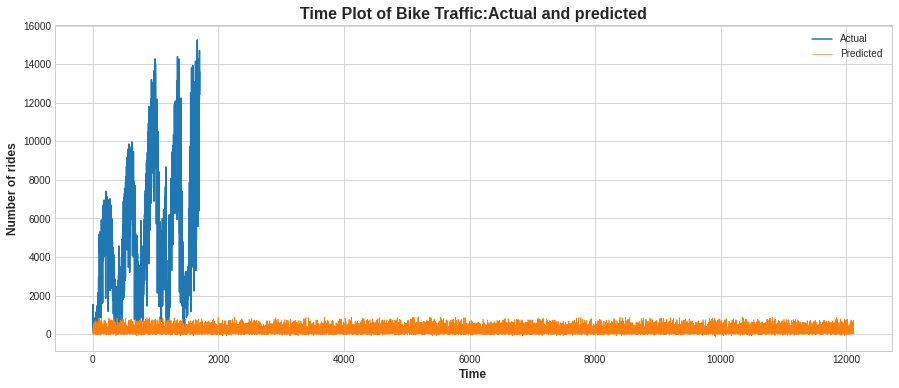

In [ ]:
y_pred = pd.DataFrame(y_pred)
ax = y.plot()
ax = y_pred.plot(ax=ax, linewidth=.7)
plt.legend(['Actual','Predicted'])
ax.set_title('Time Plot of Bike Traffic:Actual and predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides')

Text(0, 0.5, 'Number of rides')

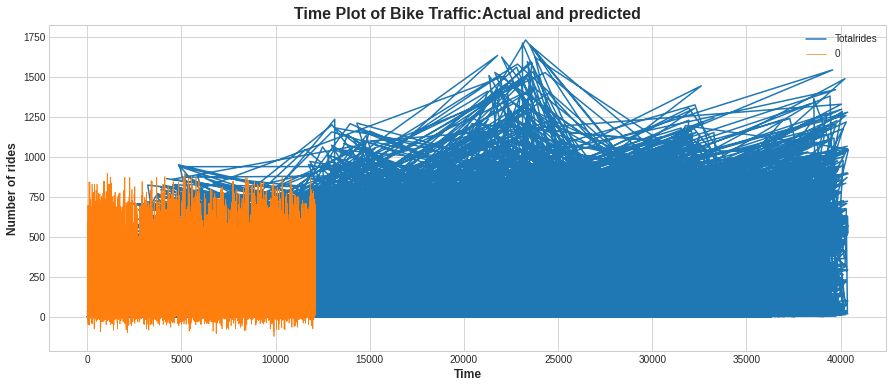

In [ ]:
import matplotlib as plt
ax = pd.DataFrame(y_test).plot()
ax = pd.DataFrame(y_pred).plot(ax=ax, linewidth=.7)
#plt.legend(['Actual','Predicted'])
ax.set_title('Time Plot of Bike Traffic:Actual and predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides')
# pd.DataFrame(y_test).plot()
# pd.DataFrame(y_pred).plot()

## spiltting the test and train according to time

In [ ]:
# preprocessing
def preprocess(data):
  '''
  Etract day, month, hour from timestamp
  new features such as seasons and weekday and weekend
  one hot encoding
  grouping by hour

  '''
  df = data.copy()
  
  # extracting the date,hour from time stamp
  df['date'] = df.starttime.dt.date
  df['hour'] = df.starttime.dt.hour

  # getting the count by the hour
  df = df.groupby(['date','hour']).size().reset_index(name = 'Totalrides')
  df['date'] = pd.to_datetime(df['date'])
  
  # extracting the date,hour from time stamp
  df['year'] = df.date.dt.year
  df['month'] = df.date.dt.month
  df['day'] = df.date.dt.day_name()
  df['day_of_year'] = pd.to_numeric(df.date.dt.strftime('%j'))

  # new features for seasons
  df['Winter'] =df['month'].apply(lambda x: 1 if x in (12,1,2) else 0) 
  df['Spring'] =df['month'].apply(lambda x: 1 if x in (3,4,5) else 0)
  df['Summer'] =df['month'].apply(lambda x: 1 if x in (6,7,8) else 0)
  df['Fall'] =df['month'].apply(lambda x: 1 if x in (9,10,11) else 0)
  
  # new feature for weekday
  df['Weekday'] =df['day'].apply(lambda x: 1 if x not in ('Saturday','Sunday') else 0)
  df['Weekend'] =df['day'].apply(lambda x: 1 if x in ('Saturday','Sunday') else 0)
  
  # new feature for holiday
  import holidays
  holiday_list = holidays.US() 
  df['holiday'] =df['date'].apply(lambda x: 1 if x in holiday_list else 0)

  # split df into X and y
  X = df.drop(['Totalrides','day'],axis =1)
  y = df['Totalrides']

  # train test split
  #from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import StandardScaler
  #X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.7,shuffle = True,random_state = 1 )

  X_train = df[df.date < "2019"]
  X_test = df[df.date >="2019"]
  y_train = X_train['Totalrides']
  y_test = X_test['Totalrides']
  X_train = X_train.drop(['Totalrides','day','date'],axis =1)
  X_test = X_test.drop(['Totalrides','day','date'],axis =1)
  
  print(X_train.shape,
        X_test.shape,
        y_train.shape,
        y_test.shape)
  # Scaling the data
  # scaler = StandardScaler()
  # scaler.fit(X_train)
  # X_train = pd.DataFrame(scaler.transform(X_train),index= X_train.index,columns=X_train.columns)
  # X_test = pd.DataFrame(scaler.transform(X_test),index= X_test.index,columns=X_test.columns)
  

  return df,X_train,X_test,y_train,y_test

In [ ]:
df,X_train,X_test,y_train,y_test = preprocess(raw_data)


(17121, 11) (23280, 11) (17121,) (23280,)


In [ ]:
X_train

,hour,year,month,day_of_year,Winter,Spring,Summer,Fall,Weekday,Weekend,holiday
0,0,2017,1,1,1,0,0,0,0,1,1
1,1,2017,1,1,1,0,0,0,0,1,1
2,2,2017,1,1,1,0,0,0,0,1,1
3,3,2017,1,1,1,0,0,0,0,1,1
4,4,2017,1,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
17116,19,2018,12,365,1,0,0,0,1,0,0
17117,20,2018,12,365,1,0,0,0,1,0,0
17118,21,2018,12,365,1,0,0,0,1,0,0
17119,22,2018,12,365,1,0,0,0,1,0,0


In [ ]:
raw_data.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,350,2017-01-01 00:06:58,2017-01-01 00:12:49,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,139,Dana Park,42.361780,-71.108100,644,Subscriber,NaN
1,891,2017-01-01 00:13:16,2017-01-01 00:28:07,36,Boston Public Library - 700 Boylston St.,42.349673,-71.077303,10,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,230,Subscriber,NaN
2,1672,2017-01-01 00:16:17,2017-01-01 00:44:10,36,Boston Public Library - 700 Boylston St.,42.349673,-71.077303,9,Agganis Arena - 925 Comm Ave.,42.351246,-71.115639,980,Customer,NaN


In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train,y_train)

[15:52:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([-13.281019, -17.834812, -22.435562, ..., 251.41338 , 217.21008 ,
       185.34152 ], dtype=float32)

In [ ]:
y_pr = pd.DataFrame(y_pred)
y_pr.columns=['pred']
y_pr

NameError: ignored

In [ ]:
min_val = min(y_pr.pred)
y_pr['pr'] = y_pr['pred']- min_val

NameError: ignored

In [ ]:
#l1 = range(len(y_train))
l2 = [0.0]*len(y_train)

  
# creating the DataFrame
predn = pd.DataFrame(list(zip(l2)))
predn.columns=['pr']
p = predn.append(y_pr, ignore_index = True)
p

,pr,pred
0,0.000000,NaN
1,0.000000,NaN
2,0.000000,NaN
3,0.000000,NaN
4,0.000000,NaN
...,...,...
40396,515.169159,465.096405
40397,399.874054,349.801300
40398,301.486130,251.413376
40399,267.282837,217.210083


Text(0, 0.5, 'Number of rides')

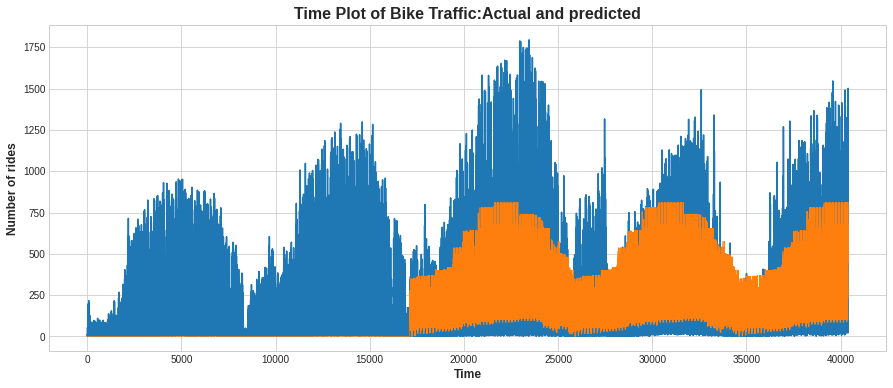

In [ ]:
import matplotlib as plt
ax = df.Totalrides.plot()
ax = p.pr.plot(ax=ax, linewidth=.7)
#plt.legend(['Actual','Predicted'])
ax.set_title('Time Plot of Bike Traffic:Actual and predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides')
# pd.DataFrame(y_test).plot()
# pd.DataFrame(y_pred).plot()

In [ ]:
from sklearn.model_selection import GridSearchCV 

In [ ]:
# params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
# 'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

# xgb = XGBRegressor(nthread=-1) 

# grid = GridSearchCV(xgb, params)
# grid.fit(X_train, y_train)

base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=-1,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),

In [ ]:
# prediction = grid.best_estimator_.predict(X_test)
# prediction

In [ ]:
# dfs = pd.DataFrame(trip_data['starttime'].dt.date)
# dfs = pd.DataFrame(dfs.groupby('starttime').size().reset_index(name='Totalrides'))
# dfs.set_index('starttime')
# dfs['Time'] = np.arange(len(dfs.index))
# train_df = dfs[dfs['starttime']<pd.to_datetime('2019-01-01')]
# max(train_df.starttime)

In [ ]:
# test_df = dfs[dfs['starttime']>=pd.to_datetime('2019-01-01')]

In [ ]:
from sklearn.linear_model import LinearRegression

# # Training data
# X = train_df.loc[:, ['Time']]  # features
# y = train_df.loc[:, 'Totalrides']  # target
# X_test = test_df.loc[:,['Time']]
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X_test), index=X_test.index)
y_pred

17121    -15.307097
17122     -6.935316
17123      1.436465
17124      9.808245
17125     18.180026
            ...    
40396    539.153815
40397    547.525595
40398    555.897376
40399    564.269156
40400    572.640937
Length: 23280, dtype: float64

In [ ]:
y_pr = pd.DataFrame(y_pred)
y_pr.columns=['pred']
y_pr

,pred
17121,-15.307097
17122,-6.935316
17123,1.436465
17124,9.808245
17125,18.180026
...,...
40396,539.153815
40397,547.525595
40398,555.897376
40399,564.269156


Text(0, 0.5, 'Number of rides')

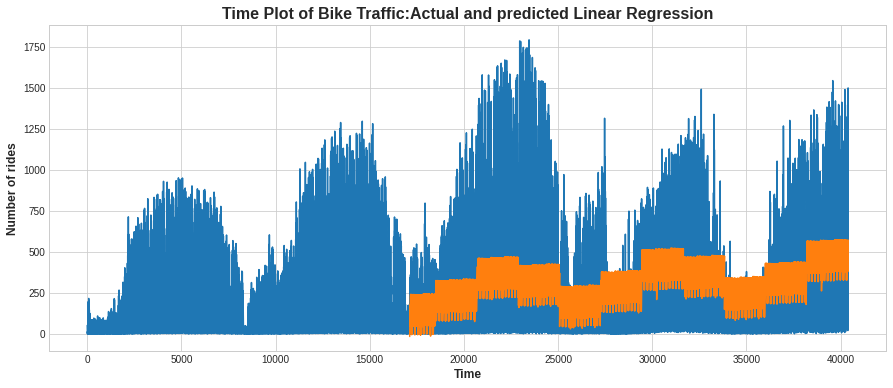

In [ ]:
import matplotlib as plt
ax = df.Totalrides.plot()
ax = y_pr.pred.plot(ax=ax)
#plt.legend(['Actual','Predicted'])
ax.set_title('Time Plot of Bike Traffic:Actual and predicted Linear Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides')
# pd.DataFrame(y_test).plot()
# pd.DataFrame(y_pred).plot()

In [ ]:
ax = y.plot()
ax = y_pred.plot(ax=ax, linewidth=.7)
plt.legend(['Actual','Predicted'])
ax.set_title('Time Plot of Bike Traffic:Actual and predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Number of rides')

In [ ]:
import numpy as np
